# GTSRB using PyTorch and Efficient CNNs

**Mistakes in other Notebooks**

- Most notebooks do not account for similarities between different pictures of the same traffic sign
- simply splitting in train- and validationdata causes inflated accuracies on validation set because almost similar images were used for training
- actual model performance cannot be assessed and the best architecture cannot be identified

**General Idea**

- use stratified sampling to avoid similar images of same traffic sign in train and validationdata
- use as few parameters as possible to create an easy model that does not take long to train
- make adjustments based on the validation accuracy
- increase complexity of the base model to improve accuracy

In [1]:
import matplotlib.pyplot as plt
import torch
from fastprogress.fastprogress import master_bar, progress_bar
import torchvision.transforms as transforms
from torchvision.models import *
import scipy.misc
import os
import cv2
from torchvision.transforms.functional import resize
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random 
import pickle
import time
import torch.nn as nn
from multiprocessing.dummy import Pool as ThreadPool
import math
import seaborn as sns
from torchsummary import summary
from ptflops import get_model_complexity_info
import torchvision.transforms as T
random.seed(42)
np.random.seed(42)
# device = torch.device("cuda:0")
device = torch.device("cpu")

# 1. Dataset preparation and split


**General Idea**

- first split the unique traffic signs into signs used for training and signs used for validation, the testdata should be a different dataset and not used for this
- decide on which percentage of images should be used for training, I chose 75%
- use offline dataaugmentation on the traindata to increase the number of images used for training, I chose to add three augmented versions of each raw image
- the augmentations I used:
    - random adjust brightness, contrast, hue
    - maybe random rotations but creates artefacts and most images of the traffic signs are almost perfectly vertically aligned
    - random perspective
    - random-crop to 95% of image size because random perspective slightly zooms out
    - randomly adjust sharpness
    - resize to 32x32 pixels
    - symmetric classes: traffic signs that can be flipped horizontally and still represent the same class of trafficsign --> probability of flip is 50%
    - mirrors classes (I didn't know what to call them): traffic signs that when flipped horizontally represent a different class --> Label has to be adjusted 
     --> Probability of flip depends on how often each class occurs in the traindata to keep the relative number of occurences in the augmented dataset unchanged

In [2]:
def split_data(root_dir, n_folds = 4):
    """
    root_dir --> path to folder with the data used for training and validation
    n_folds --> determines in how many folds the unique signs are partitioned, number of valids is roughly 1/n_folds times the number of images. 
    
    This function opens the root dir, creates a dict containing the unique labels, and all unique signs for each label.
    Afterwards, for each label (so each class of traffic signs) all the signs are partitioned into n_folds subsets.
    Then, one fold per class is selected and all the selected folds are combined to form the validationdata. All non selected will form the traindata.
    Finally the folds containing the unique sign names (e.g. class_10_sign_15) are replaced with ALL 30 of the full paths to the actual images (e.g. class_10_sign_15_img_10.png).
    
    A random seed is used to make sure the images are assigned to traindata and valdata the same way each time.
    """
    trainids = {}
    valids = {}
    mb = master_bar(range(len(os.listdir(root_dir))))
    for subfolder in os.listdir(root_dir):
        subfolderpath = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolderpath):
            unique_schilder = {int(f.split("_")[1]) for f in os.listdir(subfolderpath) if f.endswith(".png")}
            unique_schilder = np.array([f for f in unique_schilder])
            np.random.seed(42)
            np.random.shuffle(unique_schilder)
            folds = np.array_split(unique_schilder, n_folds)
            # fold = folds.pop(0)
            # testids[subfolder] = [os.path.join(subfolderpath, f) for f in os.listdir(subfolderpath) if f.endswith(".ppm") and int(f.split("_")[0]) in fold]
            fold = folds.pop(0)
            valids[subfolder] = [os.path.join(subfolderpath, f) for f in os.listdir(subfolderpath) if  f.endswith(".png") and int(f.split("_")[1]) in fold]
            trainids[subfolder]= [os.path.join(subfolderpath, f) for f in os.listdir(subfolderpath) if  f.endswith(".png") and int(f.split("_")[1]) in np.concatenate(folds)]

    return trainids, valids

def get_full_traindata(root_dir):
    """
    Opens root_dir and returns a dict with all image-paths for each of the 43 Labels.
    """
    trainids = {}
    mb = master_bar(range(len(os.listdir(root_dir))))
    for subfolder in os.listdir(root_dir):
        subfolderpath = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolderpath):
            trainids[subfolder]= [os.path.join(subfolderpath, f) for f in os.listdir(subfolderpath) if  f.endswith(".png")]
    return trainids

def get_full_testdata(root_dir):
    """
    Does the same as get_full_traindata but is adjusted to the different path structure of the testdata.
    """
    testids = {}
    gt = pd.read_csv(os.path.join("../input/gtsrb-german-traffic-sign/Test.csv"))
    for index, row in gt.iterrows():
        path = os.path.join("../input/gtsrb-german-traffic-sign/", row["Path"])
        if os.path.isfile(path):
            klasse = row["ClassId"]
            try:
                testids[klasse] += [path]
            except:
                testids[klasse] = [path]
        else:
            assert False
                
    return testids


In [3]:
class GTSRB_Dataset(Dataset):
    
    def load_image(self,key_path):
        """
        key_path --> Tuple conisting of a key, which is the label of the traffic-sign and the path to the image.
        Loads the image and converts it into a usable torch.tensor. 
        Returns label and tensor.
        """
        image = torch.tensor(cv2.imread(key_path[1]),dtype = torch.float)/255
        image = image.transpose(0,2)
        image = image.transpose(1,2)
        # By default RGB channels are in BGR order, so needs to be flipped
        image = image.flip(0)
        return key_path[0],image
    
    def augment_image(self, key_image):
        """
        key_image --> Tuple of Label and the image-tensor.
        
        Only if a transformation is defined during initialization of the GTSRB_Dataset, an augmentation will be performed.
        Only if a dict with symmetric classes is given, horizontal flipping will be performed.
        Only if a dict with mirrors is given, horizontal flip and label reassignment will be performed.
        
        The augmentation is allways based on the raw image tensor, which is not yet resized! Resizing will be performed on 
        the augmented data in this function. 
        
        Returns a Label (which might have changed due to mirrors) and the augmented image of uniform size, defined during
        initialization of the GTSRB_Dataset (default is 32x32).
        
        Augmentation is not determistic so a different result will be achieved each time. (probably)
        Creating a deterministic augmentation would be great for reproducibility, but it needs to be different in each iteration
        of the augmentation.
        
        """
        label,image = key_image
        if self.transformation:
            if self.symmetric_classes[str(label).zfill(2)]:
                # self.hflipper is defined during init with probability 0.5
                image = self.hflipper(image)
            elif self.mirrored_classes[str(label).zfill(2)]:
                # If a sign of class A can be flipped to represent a sign of class B, the probability of this A-Sign being flipped is 
                # n(B)/(n(A) + n(B)) --> with n(X) meaning the absolute number of occurences of the class X in the Dataset
                # Thereby the number of unflipped signs in class A + flipped signs from class B and relabeld as A is roughly n(A).
                if np.random.rand() > (self.priors[str(label).zfill(2)]/(self.priors[str(label).zfill(2)] + self.priors[self.mirrored_classes[str(label).zfill(2)]])):
                    image = T.functional.hflip(image)
                    label = int(self.mirrored_classes[str(label).zfill(2)])
            width = image.shape[1]
            height = image.shape[2]
            # transformation is defined outside of the dataset to allow simple adjustments, see below
            image = self.transformation(image)
            # RandomCrop to 95% to induce translational movement and compensated the zoom-out induced by the random perspective
            image = T.RandomCrop((int(width*.95), int(height*.95)))(image)
        return(label, resize(image, self.im_size))

    
    def __init__(self, data_ids,  mirrored_classes, symmetric_classes, augmentation_size, transformation, im_size = [32, 32], device = "cpu"):
        """
        data_ids --> dict of labels and corresponding image paths used for the dataset.
        mirrored_classes --> dict of labels and one corresponding label or None, determines for each class which other one it represents after flipping horizontally
        symmetric_classes --> dict of labels and boolean value if they can be flipped horizontally
        augmentation_size --> int that determines number of augmented versions of each image to be added to the raw data
        transformation --> torchvision.transformation which contains a list of imagetransformations to be used during augmentation
        im_size --> Tuple with number of Pixels in x and y direction each image will be resized to, default : (32,32)
        device --> torch.device, cuda will be used by default 
        
        First the number of occurences of eacht class (priors) is counted. --> will be used with mirrors to calculate probability
        A pool of 8 threads is used to speed up the image loading process.
        A list of all tuples (label, image_tensor) is created: raw_data
        Afterwards there will be (augmentation_size)-iterations over the raw_data, augmenting eacht image individually (see function augment image)
        raw_data and augmented_data are stacked together to data tensor with all the images and label tensor containing the label for each index.
        
        These two tensors are used as the mapstyle-dataset.        
        The whole dataset is also moved to the specified device, e.g. gpu, in order to avoid memory bottlenecks during training.
    
        
        """
        
        self.priors = {str(key).zfill(2) : len(paths) for key,paths in data_ids.items()}
        self.image_paths = [(key,path) for key,paths in data_ids.items() for path in paths]
        self.mirrored_classes = mirrored_classes
        self.symmetric_classes = symmetric_classes
        self.im_size = im_size
        self.transformation = transformation
        pool = ThreadPool(8)
        self.raw_data = pool.map(self.load_image, self.image_paths)

        self.augmented_data = []

        if augmentation_size > 0:
            self.hflipper =  T.RandomHorizontalFlip(p=0.5)
            for i in range(augmentation_size):
                # I could not find a way to create a deterministic augmentation while using the pool of threads. It worked without the multithreading but just took to long.
                self.augmented_data += pool.map(self.augment_image, self.raw_data)

        
        self.data = torch.stack([resize(image, im_size) for _,image in self.raw_data] + [image for _,image in self.augmented_data]).to(torch.device(device))
        self.labels = torch.tensor([int(label) for label,_ in self.raw_data] + [int(label) for label,_ in self.augmented_data]).to(torch.uint8).to(torch.device(device))
        del self.raw_data, self.augmented_data

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    


In [4]:
# German Names for the 43 traffic-signs
klassen = { 0:'20km/h',
            1:'30km/h', 
            2:'50km/h', 
            3:'60km/h', 
            4:'70km/h', 
            5:'80km/h', 
            6:'Ende 80km/h', 
            7:'100km/h', 
            8:'120km/h', 
            9:'Überholverbot', 
            10:'Überholverbot für LKW', 
            11:'Vorfahrt an nächster Kreuzung', 
            12:'Vorfahrtsstraße', 
            13:'Vorfahrt gewähren', 
            14:'Stop', 
            15:'Durchfahrt verboten', 
            16:'Keine Fahrzeuge über 3.5t', 
            17:'Keine Einfahrt', 
            18:'Vorsicht', 
            19:'Gefährliche Linkskurve', 
            20:'Gefährliche Rechtskurve', 
            21:'Doppelkurve', 
            22:'Unebene Fahrbahn', 
            23:'Rutschige Fahrbahn', 
            24:'Einengung an der rechten Fahrbanseite', 
            25:'Straßenarbeiten', 
            26:'Ampel', 
            27:'Fußgänger', 
            28:'Kinder', 
            29:'Fahrradfahrer kreuzen', 
            30:'Glätte',
            31:'Tiere kreuzen', 
            32:'Ende der Verkehrsbeschränkung', 
            33:'Rechts abbiegen', 
            34:'Links abbiegen', 
            35:'Nur Geradeaus', 
            36:'Geradeaus oder rechts', 
            37:'Geradeaus oder links', 
            38:'Rechts halten', 
            39:'Links halten', 
            40:'Kreisverkehr', 
            41:'Ende des Überholverbots', 
            42:'Ende des Überholverbots für Fahrzeuge über 3,5t' }

# dict with booleans if class can be flipped
symmetric = {'00': False, '01': False, '02': False, '03': False, '04': False, '05': False, '06': False, '07': False, '08': False, '09': False, '10': False, '11': True, '12': True, '13': True, '14': False, '15': True, '16': False,
             '17': True, '18': True, '19': False, '20': False, '21': False, '22': True, '23': False, '24': False, '25': False, '26': True, '27': False, '28': False, '29': False, '30': True, '31': False, '32': False, '33': False,
             '34': False, '35': True, '36': False, '37': False, '38': False, '39': False, '40': False, '41': False,'42': False}

# dict with other class if horizontal flipping changes class label, False otherwise
mirrors  = {'00': False, '01': False, '02': False, '03': False, '04': False, '05': False, '06': False, '07': False, '08': False, '09': False, '10': False, '11': False, '12': False, '13': False, '14': False, '15': False, '16': False,
            '17': False, '18': False, '19': '20', '20': '19', '21': False, '22': False, '23': False, '24': False, '25': False, '26': False, '27': False, '28': False, '29': False, '30': False, '31': False, '32': False, '33': '34',
            '34': '33', '35': False, '36': '37', '37': '36', '38': '39', '39': '38', '40': False, '41': False, '42': False,}

In [5]:
# The imagetransformation used for augmentation
transformation = T.Compose([
# Change brightnes up to 50%, contrast up to 10%, saturation up to 20% and no change to hue. 
  T.ColorJitter(0.5,0.1,0.2,0),
# creates artefacts and most signs are well alligned so i did not use rotation.
  T.RandomRotation(degrees=(0, 0)),
# RandomPerspective, hard to explain so best check on torchvision.RandomPerspective
  T.RandomPerspective(distortion_scale=.1, p=0.8),
# Change Sharpness up to 20%.
  T.RandomAdjustSharpness(0.8, 0.8)]
)

In [6]:
# First, the files are split into training files (trainids), and validation files (valids)
trainfolder = "./archive/Train"
trainids, valids = split_data(trainfolder,n_folds = 4)



In [7]:
# traindata is created from the trainids using all kinds of flipping and augmenting each image 3 times
# the traindata_wo_augmentation does the same but does not perform any augmentation. Therefore each image is repeated 4 times in the Dataset
# This is used to create a dataset without augmentation of identical size! Why this is needed is explained below at the model training.
# Valdata uses valids and only contains each valimage once.
traindata = GTSRB_Dataset(trainids, mirrors, symmetric,3, transformation)
traindata_wo_augmentation = GTSRB_Dataset(trainids, None, None,3, None)
valdata = GTSRB_Dataset(valids,None,None,0,None)


c:\Users\berna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


**Some examples for images in the first class, these are all raw images resized to 32x32:**

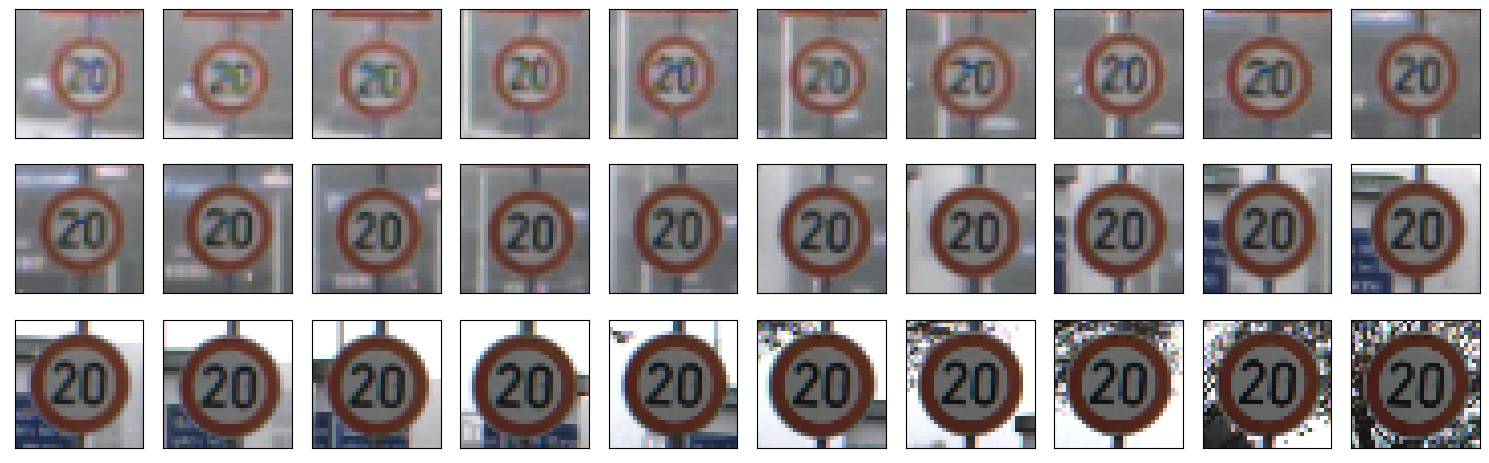

In [8]:
fig,ax = plt.subplots(3,10, figsize = (15,5), tight_layout = True, sharex = True, sharey = True)
img_paths= trainids["0"][:30]

for i in range(30):
    img = cv2.resize(cv2.imread(img_paths[i])/255, [32,32])

    ax[i//10, i%10].imshow(np.flip(img,2));
    ax[i//10, i%10].axes.get_xaxis().set_visible(False)
    ax[i//10, i%10].axes.get_yaxis().set_visible(False)

**An example for the augmentation performed on a class, that can be flipped horizontally. The black borders are due to the random perspective and the random cropping. A flip will not allways occur so maybe the index of the shown picture needs to be changed in the cell below.**

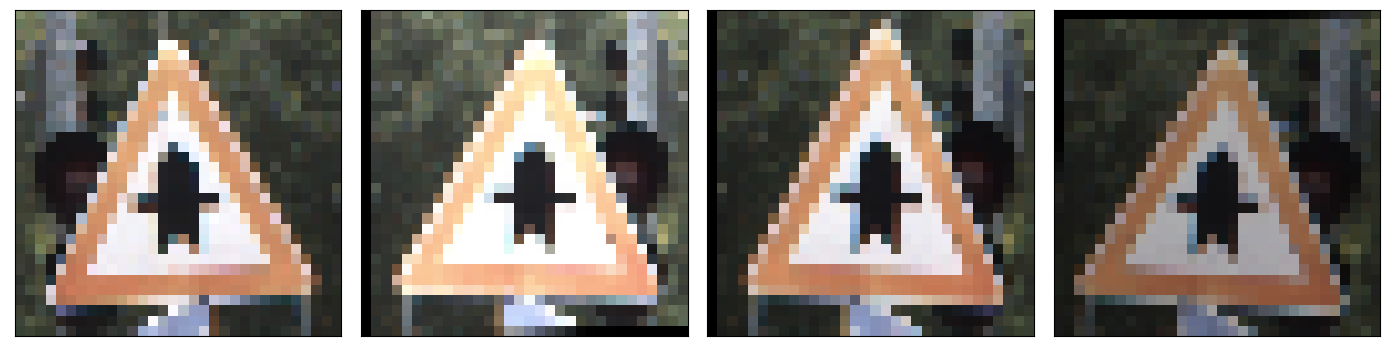

In [9]:
fig,ax = plt.subplots(1,4, tight_layout = True, figsize = (14,4), sharex = True, sharey = True)
for j,_ in enumerate(traindata.data):
    if traindata.labels[j] == 11:
        break
for i in range (4):
    # Change index added from 118 to something like 99 or 119 or 120. There should be some flipped images!
    img = traindata.data[j+118 + int(len(traindata)/4)*i]

    ax[i].imshow(img.cpu().numpy().transpose(1,2,0));
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
fig.savefig(f"Beispiel_augmentation_mit_Spiegelung.png")
    

    

**An example for the augmentation performed on a class, that can be flipped horizontally, but needs to be relabeled afterwards. A flip may not have occured so the index of the shown image needs to be changed in the hidden cell below.** 

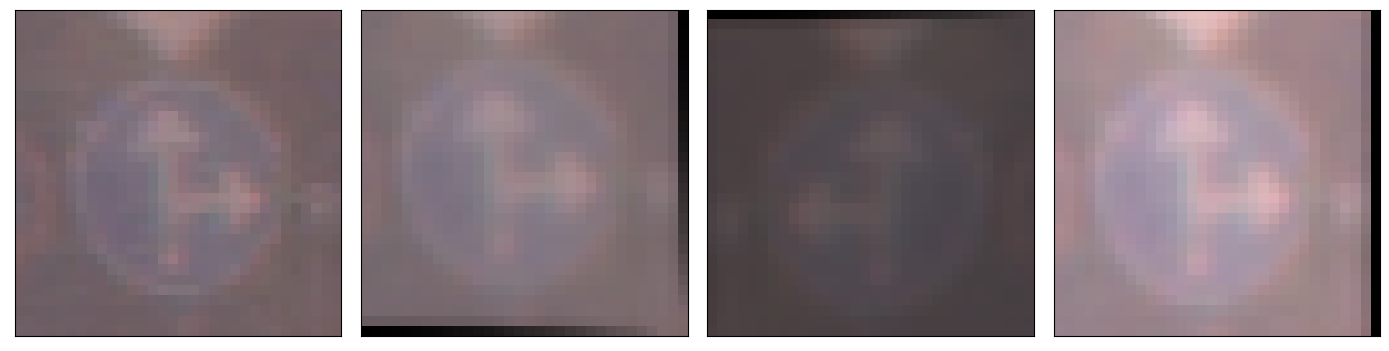

In [10]:
fig,ax = plt.subplots(1,4, tight_layout = True, figsize = (14,4), sharex = True, sharey = True)
for j,_ in enumerate(traindata.data):
    if traindata.labels[j] == 36:
        break
for i in range (4):
    img = traindata.data[j+3 + int(len(traindata)/4)*i]

    ax[i].imshow(img.cpu().numpy().transpose(1,2,0));
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
fig.savefig(f"Beispiel_augmentation_mit_Spiegelung_und_Klassenänderung.png")

# 2. Model Definition

Shivank Sharma's notebook was used as a starting point fot the architecture of the models used in this notebook. It serves as a benchmark model to compare the developed architectures to. It can be found here:
https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy


**General Idea**

- Change the number of featuremaps (channels) in all the convolutional layers --> increase or decrease using a factor multiplied with the base layer width
- make the model deeper by adding two more conv-layers 
- use a different, more efficient classifier at the end of the network
- prevent overfitting by adding 2d Dropout and accelerate training using batchnormalization


In [11]:
class Benchmark(nn.Module):
    """
    This is the Benchmark class adopted from Sharma.
    """
    def __init__(self, n_classes):
        torch.manual_seed(42)

        super(Benchmark, self).__init__()
        self.model = nn.Sequential(
          nn.Conv2d(in_channels= 3, out_channels=16, kernel_size=3, stride=1,bias = True),
          nn.ReLU(),
          nn.Conv2d(in_channels= 16, out_channels=32, kernel_size=3, stride=1,bias = True),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2),
          nn.BatchNorm2d(32),

          nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=3, stride=1,bias = True),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,bias = True),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 2),
          nn.BatchNorm2d(128),

          nn.Flatten(),
          nn.Linear(in_features=128*25, out_features=512, bias = True),
          nn.ReLU(),
          nn.BatchNorm1d(512),
          nn.Dropout(0.5),
          nn.Linear(in_features = 512, out_features = n_classes, bias = True)        
        )
    
    def forward(self, x):
        return self.model(x)

### The architecture of the benchmark-model:

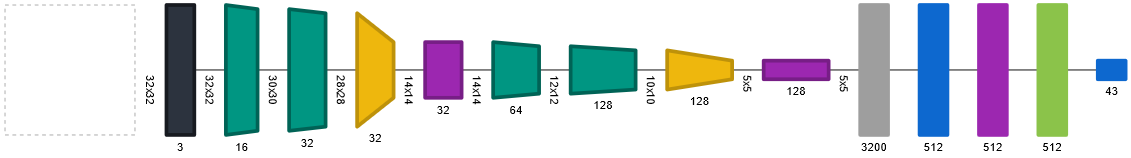

In [12]:
class Net(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False, activation = "ReLU", dropout = "Variable"):
    """
    n_classes --> int, should be 43, equal to number of classes in dataset
    conv_scaling--> float, multiplier applied to the first number of output channels in the first five convultional layers.
    conv_output_size--> int, number of channels (featuremaps) after the last convolutional layer, being handed over to the classifier
    bias --> Boolean, determine if bias is used in all the layers
    activation --> "ReLU", "Swish", "Hardswish", determines the activation-function used in all layers
    dropout --> float, >0, <1, default: Variable, probability of dropout in all dropout layers
    
    First the activation function is determined. Afterwards the dropout. If a value for the dropout is provided, it will be used. Otherwise the dropout will be determined depending
    on the conv_scaling. For some example values of the function check the appendix.
    
    
    """
    torch.manual_seed(42)

    super(Net, self).__init__()
    if activation == "Hardswish":
        activation = nn.Hardswish()
#         print("Hardswish!")
    elif activation == "Swish":
        activation = nn.SiLU()
#         print("SiLU!")
    elif activation == "ReLU":
#         print("ReLU!")
        activation = nn.ReLU()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    if dropout == "Variable":
        self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    else: 
        self.dropoutrate = dropout
    self.model = nn.Sequential(
      nn.BatchNorm2d(3),
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(16*conv_scaling)),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(64*conv_scaling)),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(256*conv_scaling)),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(conv_output_size)),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
      nn.BatchNorm1d(conv_output_size),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

### The improved architecture in the base configuration: conv_scaling = 1, conv_output_size = 1024

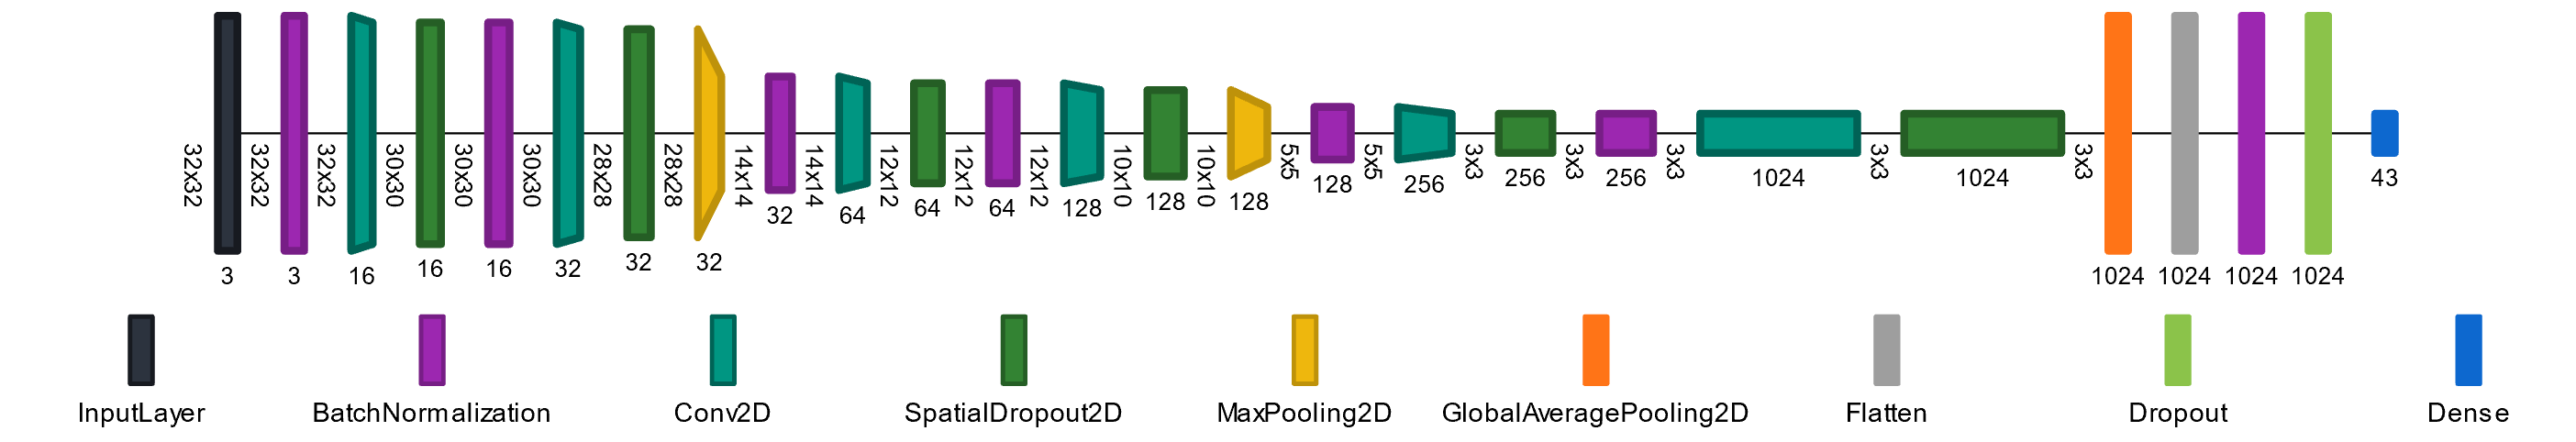

# 3 Model training

***General Idea***

- train batch size 256 might be reduced to improve accuracy but is chosen because of training time
- learning rate is linearly reduced to 1/1000 of the initial one
- training is performed over 20 epochs
- to perform the same number of steps with the optimizer and the scheduler while training with and without augmentation, the traindata_wo_augmentation contains each image 4 times
- crossentropy is used as loss function, which calculates softmax by itself, so no softmax activation is explicitly needed
- accuracy is used as an interpretable measure for the model performance
- Adam-optimizer is used


In [13]:
def train(model, traindataset, valdataset, print_outputs = True, epochs = 20):
    """
    model --> torch.model, Model to be trained
    traindataset --> GTSRB_Dataset used for training
    valdataset --> GTSRB_Dataset used for validation
    print_outputs --> Boolean, decides if the archieved accuracies are printed each epoch, and also if a list containing the loss-history is returned
    epochs --> int, number of epochs to be trained.
    
    Returns: Tuple of: last accuracy on traindata, last accuracy on valdata, list containing losshistory and accuracy history (empty if not printed)
    
    In each epoch the losses and accuracys are calculated for traindata and valdata. If print_outputs, they are appended to a list and also printed.
    
    
    """
    
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic=True
    device = torch.device("cpu")
    # trainloader is shuffled, valloader isnt. Changing Batch_size will change the results.
    trainloader = DataLoader(traindataset, batch_size=256, shuffle=True, drop_last = False, num_workers = 0, pin_memory = False)
    # batchsize of valloader can be increased to decrease time usage without changing results
    valloader = DataLoader(valdataset, batch_size= 512, shuffle=False, drop_last= False, num_workers = 0, pin_memory = False)

    criterion = nn.CrossEntropyLoss()  
    # initial learning rate is set to 0.001, which is the default value
    optimizer  = torch.optim.Adam(model.parameters(),lr = 0.001)
    # scheduler reduces learning rate to 1/1000 of the optimizers intial one, update is performed with each optimization step, so many times per epoch
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.0001, total_iters=len(trainloader)*epochs, last_epoch=- 1, verbose=False)

    val_losses = []
    val_accuracy = []
    train_losses = []
    train_accuracy = []
    mb = master_bar(range(epochs))
    for epoch in mb:
        
        # counters for correct classifications and loss
        correct_train = 0
        correct_val = 0
        loss_train = 0
        loss_val = 0
        model.train()

        for inputs,labels in progress_bar(trainloader, parent = mb):
            optimizer.zero_grad()
            # data is sent to device (gpu) if not already on it, (it is checked first if they are already in that devices memory)
            # if this wasnt the case, moving the data from gpu memory to ram back to gpu memory would increase inference time a lot
            inputs = inputs.to(device)
            labels = labels.to(device)
            # inference of model on inputs
            outputs=model(inputs)
            # crossentropy between outputs and labels, note that labels is a 1d integer tensor with length batch-size and outputs is a 2d float tensor of size (batch_size x 43)
            loss = criterion(outputs, labels)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()
            # this should be changed! this line determines the predicted index for each image by choosing the index with highest predicted value (probability)
            # i do not know the implementation of topk, so using argmax may be slightly faster, topk probably sorts by value and returns selected number of values from the front
            _,pred_idxs = torch.topk(outputs, 1)
            correct_train += torch.eq(labels, pred_idxs.squeeze()).sum().item()
            scheduler.step()
        acc_train = correct_train/len(traindataset)
        loss_train = loss_train/len(trainloader)

        if valdataset:
            # set model eval to not use dropout and moving average estimation in Batchnorm layers 
            model.eval()
            # set torch.no_grad() to not calculate gradients, because they would not be used
            with torch.no_grad():
                for inputs, labels in progress_bar(valloader, parent = mb):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_val += loss.item()

                    _,pred_idxs = torch.topk(outputs, 1)
                    correct_val += torch.eq(labels, pred_idxs.squeeze()).sum().item()
        
            acc_val = correct_val/len(valdataset)
            loss_val = loss_val/len(valloader)
        
            if print_outputs:

                val_losses.append(loss_val)
                val_accuracy.append(acc_val)
                train_losses.append(loss_train)
                train_accuracy.append(acc_train)

                print(f"Epoch: {epoch}  Train_Accuracy: {acc_train}  Val_Accuracy: {acc_val} Loss: {loss_train} Val_Loss: {loss_val}")
    return acc_train, acc_val, [train_losses, val_losses, train_accuracy, val_accuracy]


## Performing a gridsearch to optimize conv_scaling, conv_output_size, and check if the dataaugmentation works as intended

**How long does training a model roughly take?**

- Conv-Scaling = 0.25:   1min 55 sec
- Conv-Scaling = 0.5:    2min 10 sec
- Conv-Scaling = 1:      2min 50
- Conv-Scaling = 2:      6min
- Conv-Scaling = 4:      13min

In [15]:
print(f"Conv_Scaling --- Conv_output_size --- Augmentation --- MACs --- Parameter --- Accuracy Training --- Accuracy Validation")

# These are the values I tested in an extensive gridsearch. Running this would take almost 4 hours, so i reduced it.

# for skalierungsfaktor in [0.25,0.5,1,2,4]:
#     for final_conv_channels in [256,512,1024,2048]:
#         for augmentation in [True, False]:


data = []
for skalierungsfaktor in [0.25,0.5,2]:
    for final_conv_channels in [256,1024]:
        for augmentation in [True, False]:
            
            model = Net(43, skalierungsfaktor, final_conv_channels,  False).to(device)
            # with torch.cuda.device(0):
            # Function is used to calculate MACs and parameter of a Model
            # Parameter is independent of the input, but with larger input images, filter need to cover more inputs and therefor more MACs are produced
            macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=False,
                                               print_per_layer_stat=False, verbose=False)
            # augmentation decides which dataset is used
            if augmentation:
                acc_train,acc_val,_ = train(model, traindata, valdata, False)
            else:
                acc_train,acc_val,_ = train(model, traindata_wo_augmentation, valdata, False)

            print(f"{str(skalierungsfaktor).zfill(3)} --- {str(final_conv_channels)} --- {str(augmentation)} --- {str(macs)} --- {str(params)} --- {str(acc_train)} --- {str(acc_val)}")
            data.append([skalierungsfaktor, final_conv_channels, augmentation, macs, params, acc_train, acc_val])
  
df = pd.DataFrame(data,columns = ["Skalierungsfaktor","Kanäle nach letzter Konvolution","Datenaugmentation","MACs","Parameter","Genauigkeit Training","Genauigkeit Validierung"]) 

KeyboardInterrupt: 

**Training of the benchmarkmodel on unaugmented data. Notice the accuracy on the traindata.**

In [ ]:
benchmark_model = Benchmark(43)
benchmark_model.to(device)
# model.cuda(0);
# display(summary(benchmark_model, (3,32,32)))
# with torch.cuda.device(0):
macs, params = get_model_complexity_info(benchmark_model, (3, 32, 32), as_strings=False,
                                          print_per_layer_stat=False, verbose=False)
#   print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#   print('{:<30}  {:<8}'.format('Number of parameters: ', params))


# here the losshistory is saved, so it can be visualized lateron
acc_train, acc_val,losshistory_benchmarkmodell_no_augmentation  = train(benchmark_model, traindata_wo_augmentation, valdata)
df.loc[len(df)] = ["Vergleichsmodell" ,"Vergleichsmodell", False, macs, params, acc_train,acc_val]



Epoch: 0  Train_Accuracy: 0.9695585339735396  Val_Accuracy: 0.9646198830409357 Loss: 0.1284064843145119 Val_Loss: 0.11739523453815352
Epoch: 1  Train_Accuracy: 0.9999913641231131  Val_Accuracy: 0.971150097465887 Loss: 0.000752035295269524 Val_Loss: 0.09177617302408353
Epoch: 2  Train_Accuracy: 1.0  Val_Accuracy: 0.9723196881091618 Loss: 0.0002263926695943625 Val_Loss: 0.09005206150634747
Epoch: 3  Train_Accuracy: 1.0  Val_Accuracy: 0.9726120857699805 Loss: 0.00013372641609684578 Val_Loss: 0.08980734109285377
Epoch: 4  Train_Accuracy: 1.0  Val_Accuracy: 0.973391812865497 Loss: 8.762610898946543e-05 Val_Loss: 0.08700332165850948
Epoch: 5  Train_Accuracy: 1.0  Val_Accuracy: 0.9742690058479532 Loss: 6.09470911830418e-05 Val_Loss: 0.08562043453760755
Epoch: 6  Train_Accuracy: 1.0  Val_Accuracy: 0.9754385964912281 Loss: 4.5288798457605735e-05 Val_Loss: 0.08448579393249626
Epoch: 7  Train_Accuracy: 1.0  Val_Accuracy: 0.9755360623781676 Loss: 3.3804655352973065e-05 Val_Loss: 0.0847612856270556

**Training of the benchmarkmodel on augmented data. Augmentation seems to reduce the overfitting but does not completely avert it.**

In [ ]:
benchmark_model = Benchmark(43)
benchmark_model.to(device)
# model.cuda(0);
# display(summary(benchmark_model, (3,32,32)))
# with torch.cuda.device(0):
macs, params = get_model_complexity_info(benchmark_model, (3, 32, 32), as_strings=False,
                                           print_per_layer_stat=False, verbose=False)
#   print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
#   print('{:<30}  {:<8}'.format('Number of parameters: ', params))
acc_train, acc_val, _ = train(benchmark_model, traindata, valdata)
df.loc[len(df)] = ["Vergleichsmodell" ,"Vergleichsmodell", True, macs, params, acc_train,acc_val]



Epoch: 0  Train_Accuracy: 0.9493333103043283  Val_Accuracy: 0.9647173489278752 Loss: 0.20201989510415275 Val_Loss: 0.11992944292502389
Epoch: 1  Train_Accuracy: 0.9965370133683374  Val_Accuracy: 0.980896686159844 Loss: 0.014207294809058408 Val_Loss: 0.06557082962189313
Epoch: 2  Train_Accuracy: 0.9985664444367681  Val_Accuracy: 0.9842105263157894 Loss: 0.006147764067172749 Val_Loss: 0.056512609959879355
Epoch: 3  Train_Accuracy: 0.9988514283740371  Val_Accuracy: 0.9799220272904483 Loss: 0.00491974762404208 Val_Loss: 0.07342301587570026
Epoch: 4  Train_Accuracy: 0.9983591833914816  Val_Accuracy: 0.9868421052631579 Loss: 0.005946375160323478 Val_Loss: 0.05556031862492784
Epoch: 5  Train_Accuracy: 0.9996027496632008  Val_Accuracy: 0.987037037037037 Loss: 0.0017687094328424145 Val_Loss: 0.053489937846149714
Epoch: 6  Train_Accuracy: 0.9994127603716881  Val_Accuracy: 0.9792397660818714 Loss: 0.002092508345370918 Val_Loss: 0.09698726851049633
Epoch: 7  Train_Accuracy: 0.9988859718815849  Val

In [ ]:
# df.to_csv("Ergebnisse.csv", index = False)

# 4. Results

These are the results I obtained in an extensive gridsearch:

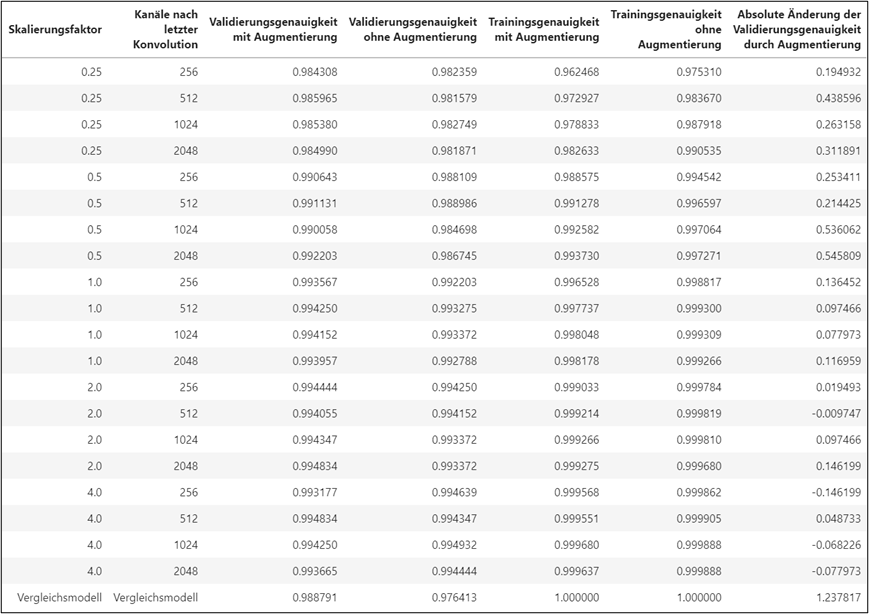


## 4.1. Comparing the different models

The results depend on the parameters tested in the grid search but also the data augmentation so different results have to be expected in multiple runs of this notebook. But in general the chosen architecture performs great! When using the same number of parameters as the benchmark-model the validation accuracy increases by about **0.6** percent. Also, almost the same accuracy as the benchmark-model can be reached with just a tenth of the needed MACs. The chosen architecture seems to be very efficient.

The accuracy rises if the conv_scaling is increased but after reaching conv_scaling = 2 the improvments are vanishing. The  conv_output_size does not show such a clear trend. Note that for each cluster of conv_scalings, larger conv_output_sizes can be found to the right of the cluster (higher number of parameters and MACs). 

In [ ]:
## if you don't perform the whole grid search, I created a csv with the results that I obtained which can be used instead
try:
    df = df
except:
    df = pd.read_csv("../input/ergebnisse-gs/Ergebnisse (9).csv")

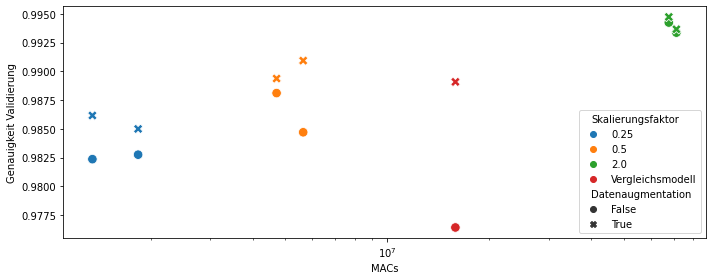

In [ ]:
fig,ax = plt.subplots(figsize = (10,4), tight_layout = True)
sns.scatterplot(data = df.sort_values(["Datenaugmentation", "Skalierungsfaktor"], ascending = True), x = "MACs",y = "Genauigkeit Validierung", hue = "Skalierungsfaktor", palette = "tab10", s = 90, style = "Datenaugmentation")
ax.set_xscale("log")

fig.savefig("Genauigkeit_über_MACs.png")


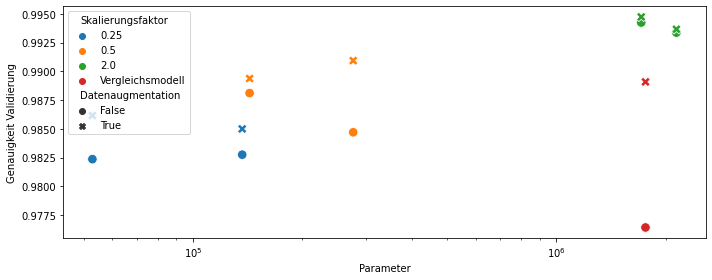

In [ ]:
fig,ax = plt.subplots(figsize = (10,4), tight_layout = True)
sns.scatterplot(data = df.sort_values(["Datenaugmentation", "Skalierungsfaktor"], ascending = True), x = "Parameter",y = "Genauigkeit Validierung", hue = "Skalierungsfaktor", palette = "tab10", s = 90, style = "Datenaugmentation")
ax.set_xscale("log")

fig.savefig("Genauigkeit_über_Parameter.png")


## 4.2 Gained accuracy by using augmented Data

The benchmarkmodel profits from augmented data quite substantially and the validation increases by more than one percent (at least in my tests). The reason is seen in the reduced overfitting and better generalisation. The improved architecture also profits from augmentation, but only for the smaller models. More complex models with higher conv_scaling do not improve when used with data augmentation. This is surprising, since larger models usually have a higher tendency to overfit on the data and the same improvements as for the benchmarkmodel were expected.

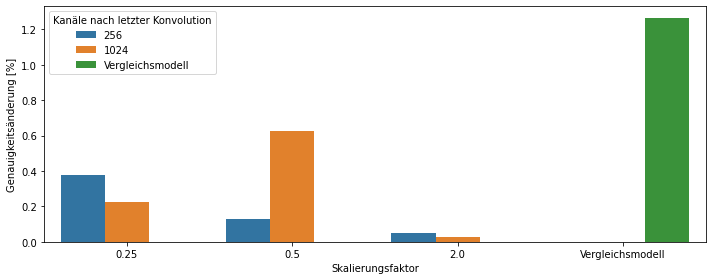

In [ ]:
augmentation_gain_df = df.sort_values("Datenaugmentation",ascending = False).groupby(["Skalierungsfaktor","Kanäle nach letzter Konvolution"], as_index = False).agg({"Genauigkeit Validierung":["first","last"], "Genauigkeit Training":["first","last"]}).reset_index()
augmentation_gain_df["Genauigkeitsänderung [%]"] =  (augmentation_gain_df[("Genauigkeit Validierung","first")]-augmentation_gain_df[("Genauigkeit Validierung","last")])*100


# import seaborn as sns
fig,ax = plt.subplots(figsize = (10,4), tight_layout = True)
sns.barplot(data = augmentation_gain_df.sort_values(["Skalierungsfaktor", "Kanäle nach letzter Konvolution"], ascending = True), x = "Skalierungsfaktor",y = "Genauigkeitsänderung [%]", hue = "Kanäle nach letzter Konvolution", palette = "tab10")
# ax.set_xscale("log")
fig.savefig("Gewinn_durch_DA.png")

In [ ]:
augmentation_gain_df.drop(("index",""),1,inplace = True)

augmentation_gain_df.columns = ["Skalierungsfaktor","Kanäle nach letzter Konvolution", "Validierungsgenauigkeit mit Augmentierung","Validierungsgenauigkeit ohne Augmentierung","Trainingsgenauigkeit mit Augmentierung","Trainingsgenauigkeit ohne Augmentierung", "Absolute Änderung der Validierungsgenauigkeit durch Augmentierung"]
augmentation_gain_df.Skalierungsfaktor = pd.Categorical(augmentation_gain_df["Skalierungsfaktor"],categories = ["0.25","0.5","1.0","2.0","4.0","Vergleichsmodell"])
augmentation_gain_df["Kanäle nach letzter Konvolution"] = pd.Categorical(augmentation_gain_df["Kanäle nach letzter Konvolution"],categories = ["256","512","1024","2048","Vergleichsmodell"])

augmentation_gain_df.sort_values(["Skalierungsfaktor","Kanäle nach letzter Konvolution"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,Skalierungsfaktor,Kanäle nach letzter Konvolution,Validierungsgenauigkeit mit Augmentierung,Validierungsgenauigkeit ohne Augmentierung,Trainingsgenauigkeit mit Augmentierung,Trainingsgenauigkeit ohne Augmentierung,Absolute Änderung der Validierungsgenauigkeit durch Augmentierung
6,Vergleichsmodell,Vergleichsmodell,0.989084,0.976413,0.999991,1.000000,1.267057
0,NaN,NaN,0.986160,0.982359,0.963298,0.975310,0.380117
1,NaN,NaN,0.984990,0.982749,0.979308,0.987918,0.224172
2,NaN,NaN,0.989376,0.988109,0.988652,0.994542,0.126706
3,NaN,NaN,0.990936,0.984698,0.993195,0.997064,0.623782
4,NaN,NaN,0.994737,0.994250,0.999136,0.999784,0.048733
5,NaN,NaN,0.993665,0.993372,0.999465,0.999810,0.029240


## 4.3. Comparison of Losshistories of the benchmarkmodell and a parametrisation of comparable performance

The model with conv_scaling 0.25 and 256 conv_output_size is trained again, but this time the losshistory is saved. Thereby the training can be compared to the one of the benchmarkmodel. In both cases the traindata_wo_augmentation was used, to obtain reproducible results.

In [ ]:
model = Net(43, 0.25, 256, False).to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
_,_, Losshistory_own_model = train(model, traindata_wo_augmentation, valdata, True)

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.3762133407026149  Val_Accuracy: 0.7346978557504873 Loss: 2.1137511732825645 Val_Loss: 0.9610267586651302
Epoch: 1  Train_Accuracy: 0.772271926491416  Val_Accuracy: 0.9283625730994152 Loss: 0.7367550116237952 Val_Loss: 0.27747327488447937
Epoch: 2  Train_Accuracy: 0.8846074130367197  Val_Accuracy: 0.9591617933723197 Loss: 0.3771178133900855 Val_Loss: 0.13940541743345203
Epoch: 3  Train_Accuracy: 0.9183477840339909  Val_Accuracy: 0.9678362573099415 Loss: 0.26805192028186703 Val_Loss: 0.10659070736506865
Epoch: 4  Train_Accuracy: 0.9326919755431966  Val_Accuracy: 0.9758284600389864 Loss: 0.2182731254573163 Val_Loss: 0.08346859046391078
Epoch: 5  Train_Accuracy: 0.9439963383882  Val_Accuracy: 0.9771929824561404 Loss: 0.18075870676480119 Val_Loss: 0.08235540283134296
Epoch: 6  Train_Accuracy: 0.9498773705482054  Val_Accuracy: 0.974561403508772 Loss: 0.1621842294865623 Val_Loss: 0.08541424104589082
Epoch: 7  Train_Accuracy: 0.9556979515700024  Val_Accuracy: 0.9777

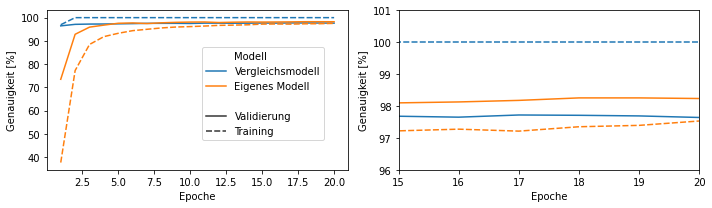

In [ ]:
# both losshistorys are first converted into dataframes to be stacked lateron

Loss_df = pd.DataFrame(np.array(losshistory_benchmarkmodell_no_augmentation).T, columns = ["Verlust Training", "Verlust Validierung","Training","Validierung"])
Loss_df["Modell"] = "Vergleichsmodell"
Loss_df["Epoche"] = Loss_df.index

Loss_df_own =  pd.DataFrame(np.array(Losshistory_own_model).T, columns = ["Verlust Training", "Verlust Validierung","Training","Validierung"])
Loss_df_own["Modell"] = "Eigenes Modell"
Loss_df_own["Epoche"] = Loss_df_own.index

Losshistory = pd.concat([Loss_df,Loss_df_own])
Losshistory.Epoche = Losshistory.Epoche+1

# Melting the dataframe is used to put the accuracies in the same column and create a new colum, which contains the information wether this accuracy corresponds to training- or validationdata
# this allows very easy plotting
Losshistory = pd.melt(Losshistory, id_vars = ["Modell","Epoche"], value_vars = ["Validierung","Training"], var_name = " ",value_name = "Genauigkeit [%]")
Losshistory["Genauigkeit [%]"] = Losshistory["Genauigkeit [%]"] * 100

fig,ax = plt.subplots(1,2,figsize = (10,3), tight_layout = True)
sns.lineplot(ax = ax[0], data = Losshistory, x = "Epoche",y = "Genauigkeit [%]" ,hue = "Modell", style = " ", palette = "tab10")
sns.lineplot(ax = ax[1], data = Losshistory, x = "Epoche",y = "Genauigkeit [%]" ,hue = "Modell", style = " ", palette = "tab10")
# ax.set_yscale("log")
ax[1].set(xlim = [15,20])
ax[1].set(ylim = [96,101])

ax[1].get_legend().remove()
ax[0].legend(loc="best", bbox_to_anchor=(0.5,0.8))


fig.savefig("Lossverlauf_Ausschnitt.png")

After just one Epoch, the benchmark model reaches a very high accuracy of over 96 percent on the validationdata. The accuracy on the traindata reaches 100 percent after just three epochs and does not drop below it during the following epochs. The validation accuracy only increases slightly in the reamining epochs and reaches 97.64 percent.

The improved architecture on the other hand learns a lot slower thanks to the added regularisation and also smaller model. The accuracy on traindata is consistently lower than on the validataiondata which is due to the dropout. It is less prown to overfitting and therefore can outperform the benchmarkmodel. Atleast on the unaugmented data. On the augmented data, the Loss on Traindata is expected to be even lower and the Accuracy on validationdata even higher. Performance of both models with augmentation is about the same (see results of the gridsearch). 

# 5 Predicting the testdata

To maximize performance on the testdata, the validationdata has to also be used for training. Therefore a full trainingset is created using all the data excpet the testdata. Since there are some models, that do not benefit from augmentation, one full dataset with augmented images and one without is created. 


In [ ]:
full_augmented_Dataset = GTSRB_Dataset(get_full_traindata(trainfolder), mirrors, symmetric,3, transformation)

raw_traindata = GTSRB_Dataset(get_full_traindata(trainfolder), None, None,3,None)

testfolder ="./archive/Test/"
testids = get_full_testdata(testfolder)
testdata = GTSRB_Dataset(testids,  None,None,0,None)

## 5.1 Using the models from the gridsearch to form an ensemble

The best models of each conv_scaling are trained on the full data and tested on the testdata. The results on the testdata are comparable to other notebooks and the participants of the original benchmark.

In [ ]:
# best ensemble is a dataframe that contains only the best model per conv_scaling and drops the benchmark model
best_ensemble = df.query("Skalierungsfaktor != 'Vergleichsmodell'").sort_values("Genauigkeit Validierung", ascending = False).groupby("Skalierungsfaktor").agg("first").reset_index()
best_ensemble.sort_values(["Genauigkeit Validierung"], ascending = False, inplace = True)

# iterate over the dataframe, so the modelsparameters, initialize new model for each row, and train model on the data that works best for them (augmentation True or False?)
# Performance on testdata is tracked and the accuracy after the last epoch ist printed
# trained models are appended to list to be used afterwards in an ensemble
# also, the modelarchitecture will be printed before the validataion Accuracy
trained_models = []
for _,row in best_ensemble.iterrows():
    print(row)
    model = Net(43, float(row[0]), int(row[1]),  False).to(device)
#     print("Genauigkeit Training, Genauigkeit Validierung:")
    if row[2]:
        acc_train,acc_val,_ = train(model, full_augmented_Dataset, testdata, False)
    else:
        acc_train,acc_val,_ = train(model, raw_traindata, testdata, False)
    print(acc_val)
    trained_models.append(model)

Skalierungsfaktor                         2.0
Kanäle nach letzter Konvolution           256
Datenaugmentation                        True
MACs                               67651584.0
Parameter                             1712806
Genauigkeit Training                 0.999136
Genauigkeit Validierung              0.994737
Name: 2, dtype: object


0.9921615201900238
Skalierungsfaktor                        0.5
Kanäle nach letzter Konvolution         1024
Datenaugmentation                       True
MACs                               5642304.0
Parameter                             275950
Genauigkeit Training                0.993195
Genauigkeit Validierung             0.990936
Name: 1, dtype: object


0.9853523357086302
Skalierungsfaktor                       0.25
Kanäle nach letzter Konvolution          256
Datenaugmentation                       True
MACs                               1347360.0
Parameter                              52826
Genauigkeit Training                0.963298
Genauigkeit Validierung              0.98616
Name: 0, dtype: object


0.9749010292953286


**Check the Performance of the benchmarkmodel on the testdata:** 

In [ ]:
print("Accuracy Traindata, Accuracy on Testdata, Losshistory is empty if print is set to False in train function")
model = Benchmark(43).to(device)
train(model, full_augmented_Dataset, testdata, False)

Accuracy Traindata, Accuracy on Testdata, Losshistory is empty if print is set to False in train function


(1.0, 0.9871733966745844, [[], [], [], []])

**Now the trained models in the ensemble are used to predict the testdata.**

In [ ]:
# testloadeer is otherwise defined in the train function, but models are allready trained
# instead you could also just enumerate the traindata.data as it will be done lateron in this notebook
testloader = DataLoader(testdata, batch_size= 512, shuffle=False, drop_last= False)

# works just like in the train function: predictions are compared with true label and if its the same, correct_test counter is increased
correct_test = 0
for model in trained_models:
    model.eval()
with torch.no_grad():
  for i, data in enumerate(testloader, 0):
    inputs, labels =  data
    outputs = torch.stack([model(inputs.cuda(0)) for model in trained_models]).sum(0)
    _,pred_idxs = torch.topk(outputs, 1)
    correct_test += torch.eq(labels, pred_idxs.squeeze()).sum().item()
print(correct_test/len(testdata))



0.991765637371338


From my experiments, the best models of the grid search achieve roughly the same accuracy on the testdata. Sometimes the smaller models perform a bit worse on the testdata and only achieve 97 to 98 percent. This largely depends on the augmentation and changes from one run to another. The ensemble usually performs worse than the best single model. Reduction of variance seems to be less beneficial for the accuracy, than the smaller models worse performance is harmfull. The own, improved, modelarchitecture performs better than the benchmarkmodel by roughly the same margin as on the validationdata. Also, the benchmarkmodel performs better than in the notebook from sharma (see link above). The augmentation used seems to be an improvement compared to the augmentation used in his notebook. 

## 5.2 Results of the best model I identified

The best parameters I found is conv_scaling 4 and 1024 conv_output_size, trained without augmentation. I want to include this model since it performed the best and it did so without augmentation, which makes its performance reproducible.

In [ ]:
print("Accuracy Traindata, Accuracy on Testdata, Losshistory is empty if print is set to False in train function")
best_model = Net(43,4,1024).to(device)
train(best_model, raw_traindata, testdata, False)

Accuracy Traindata, Accuracy on Testdata, Losshistory is empty if print is set to False in train function


(0.9999362391287715, 0.9931908155186064, [[], [], [], []])

As you can see, this model reaches **99.32%** accuracy on the testdata, which is an outstanding result. To find out, how this model may be improved further, let's see where the model makes its mistakes.

Some examples for wrongly classified images:


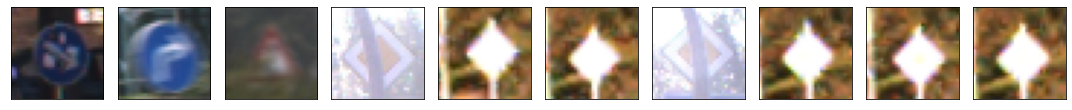

In [ ]:
# This cell will show 10 examples for wrong classsifications

fig,ax = plt.subplots(1,10,tight_layout = True, figsize = (15,3) )
imgs_per_class = torch.bincount(testdata.labels)
correct_klasses = torch.zeros_like(imgs_per_class)
model.eval()
j = 0
with torch.no_grad():
  for i, inputs in enumerate(testdata.data):
    label = testdata.labels[i]
    outputs = best_model(inputs.unsqueeze(0))
    # here argmax is used to determine the predicted class instead of topk
    pred_idx = torch.argmax(outputs)
    correct_klasses[int(label)] += (int(label) == int(pred_idx))
    if int(label) != int(pred_idx) and j < 10:
        ax[j].axes.get_xaxis().set_visible(False)
        ax[j].axes.get_yaxis().set_visible(False)
        ax[j].imshow(inputs.cpu().numpy().transpose(1,2,0));
        j += 1
print("Some examples for wrongly classified images:")
plt.show()
fig.savefig(f"Falsche_Klassifizierung.png")

class_accuracys = (correct_klasses/imgs_per_class)
abs_wrong = imgs_per_class-correct_klasses


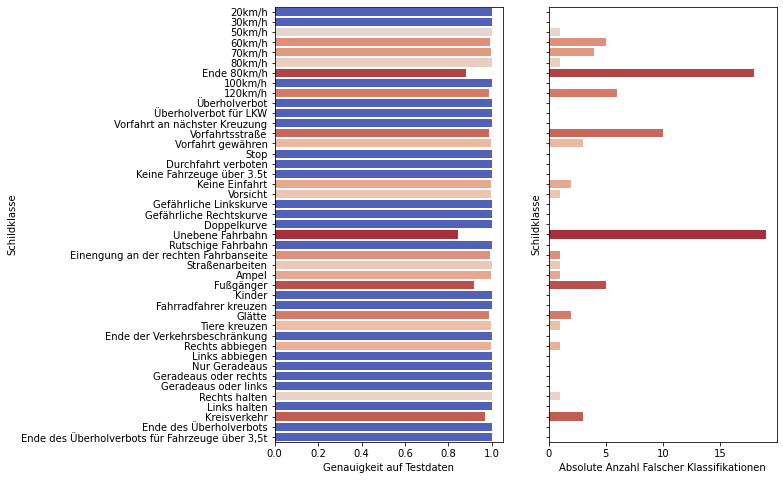

In [ ]:
data = []
for i in range(43):
    data.append([klassen[i], class_accuracys[i].item(), abs_wrong[i].item()])
cls_accuracy_df = pd.DataFrame(data, columns = ["Schildklasse", "Genauigkeit auf Testdaten", "Absolute Anzahl Falscher Klassifikationen"])
val_order = cls_accuracy_df['Genauigkeit auf Testdaten'].rank(method='max').astype(int) # rank ordered values in column 't'
val_index = val_order - 1 # convert for use as a list index
colors = sns.color_palette('coolwarm_r', len(cls_accuracy_df.index)) # list of N colors spaced along coolwarm
palette = [colors[x] for x in val_index] #
fig,ax = plt.subplots(1,2,figsize = (9,8), tight_layout = False, sharey = True)
sns.barplot(ax = ax[0], data = cls_accuracy_df, y ="Schildklasse", x = "Genauigkeit auf Testdaten", palette = palette)
sns.barplot(ax = ax[1], data = cls_accuracy_df, y ="Schildklasse", x = "Absolute Anzahl Falscher Klassifikationen", palette = palette)

fig.savefig("Fehler_auf_Testdaten.png")

As the graph shows, there is a 100% accuracy on many classes of traffic signs. Most of the mistakes are made on a very small number of classes. The reason for this are some hard to classify signs, e.g. due to unusual lighting, lack of sharpness, lack of contrast or rotations. Since subsequent pictures are very similar, mistakes are often made on not just one image, but also the preceiding and foloowing ones.  

# 6. Appendix

This chapter includes some tests to see, if other designchoices would have had a positive impact on the models performance.
For the comparison only the model with Skalierungsfaktor = 1 and "Kanäle nach letzter Konvolution" = 512 will be used, because it is very fast to train, performs closely to the best models and does not depend on augmented data. Training without augmentation is used to achieve reproducible results. These are just simple test and a grid search is needed to actually see if these changes can or can not improve the models.

Tested changes:

1. Add bias to kernels in Convolution

2. Change position of batchnorm-layers: between convolution and activation OR between activation and dropout

3. Change activation to Swish (SiLU) OR Hardswish

4. Removed 2d-Dropout

5. Removed Batchnorm and not affine Batchnorm

6. Effect of fixed Dropout


In [ ]:
# This is the architecture used in the whole notebook. 
model = Net(43, 1,512,  False, "ReLU").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, False)


Genauigkeit Training, Genauigkeit Validierung:


(0.9993004939721579, 0.9932748538011696, [[], [], [], []])

## 6.1 Performance with bias in convolutions

Using bias with batchnorm (in its original position) is not recommended/not needed. But also when batchnorm is placed just before the convolutions, using bias does not improve the overall result.

In [ ]:
model = Net(43, 1, 512,  True, "ReLU").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, False)

Genauigkeit Training, Genauigkeit Validierung:


(0.9991364123113061, 0.9923976608187135, [[], [], [], []])

## 6.2 Performance of best model parametrisation with different position of batchnorm layers

The position of the batchnorm layer seems to not matter when it comes to , although for some models there was a small improvement in training speed (reaches higher accuracy in first few epochs) observed, when placed just before the convolutions.

In [ ]:
class Net_Batchnorm_pre_activation(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False):
    
    super(Net_Batchnorm_pre_activation, self).__init__()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    self.model = nn.Sequential(
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.BatchNorm2d(int(16*conv_scaling)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.BatchNorm2d(int(64*conv_scaling)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.BatchNorm2d(int(256*conv_scaling)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      nn.BatchNorm2d(int(conv_output_size)),
      nn.ReLU(),
      nn.Dropout2d(self.dropoutrate),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
class Net_Batchnorm_post_activation(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False):
    
    super(Net_Batchnorm_post_activation, self).__init__()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    self.model = nn.Sequential(
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(16*conv_scaling)),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Dropout2d(self.dropoutrate),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(64*conv_scaling)),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Dropout2d(self.dropoutrate),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(256*conv_scaling)),
      nn.Dropout2d(self.dropoutrate),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      nn.ReLU(),
      nn.BatchNorm2d(int(conv_output_size)),
      nn.Dropout2d(self.dropoutrate),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
model = Net_Batchnorm_pre_activation(43, 1, 512,  False).to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.5247245155273066  Val_Accuracy: 0.9226120857699805 Loss: 1.6277505327797357 Val_Loss: 0.29916356326568694
Epoch: 1  Train_Accuracy: 0.9335037479705689  Val_Accuracy: 0.9784600389863548 Loss: 0.24142515529399414 Val_Loss: 0.08239237510687894
Epoch: 2  Train_Accuracy: 0.9728401671905765  Val_Accuracy: 0.9861598440545809 Loss: 0.09909647504982043 Val_Loss: 0.057018938646208314
Epoch: 3  Train_Accuracy: 0.9842308888044492  Val_Accuracy: 0.9882066276803119 Loss: 0.05823307777148472 Val_Loss: 0.0535459175125219
Epoch: 4  Train_Accuracy: 0.9877025113129987  Val_Accuracy: 0.9892787524366472 Loss: 0.04345258737546258 Val_Loss: 0.05023499392908499
Epoch: 5  Train_Accuracy: 0.9915282047739128  Val_Accuracy: 0.9897660818713451 Loss: 0.031242289058206228 Val_Loss: 0.04690205452910353
Epoch: 6  Train_Accuracy: 0.9928322221838406  Val_Accuracy: 0.9902534113060428 Loss: 0.025770651418140063 Val_Loss: 0.0450213944556405
Epoch: 7  Train_Accuracy: 0.9941707831013161  Val_Accur

In [ ]:
model = Net_Batchnorm_post_activation(43,1,512,  False).to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.732978686655843  Val_Accuracy: 0.9718323586744639 Loss: 0.9522768548519143 Val_Loss: 0.10042668069668469
Epoch: 1  Train_Accuracy: 0.9798524992227711  Val_Accuracy: 0.9840155945419103 Loss: 0.07986284801469207 Val_Loss: 0.05910234452901585
Epoch: 2  Train_Accuracy: 0.9910100521606964  Val_Accuracy: 0.98635477582846 Loss: 0.0353130902745504 Val_Loss: 0.05608785710397309
Epoch: 3  Train_Accuracy: 0.9940671525786728  Val_Accuracy: 0.989083820662768 Loss: 0.0235263464312433 Val_Loss: 0.049844687398165534
Epoch: 4  Train_Accuracy: 0.9955438875263394  Val_Accuracy: 0.9882066276803119 Loss: 0.016591761799870475 Val_Loss: 0.05182014070340388
Epoch: 5  Train_Accuracy: 0.9969342637051366  Val_Accuracy: 0.9887914230019493 Loss: 0.011881612771690286 Val_Loss: 0.04988577197547697
Epoch: 6  Train_Accuracy: 0.9969256278282497  Val_Accuracy: 0.9899610136452242 Loss: 0.011455821290727352 Val_Loss: 0.04653660588237905
Epoch: 7  Train_Accuracy: 0.9976942208711873  Val_Accuracy

## 6.3 Performance with different activations

Changing the activations does not significantly change the accuracy of the models. The margins observed are within the changes from one epoch to another so probably due to the stochastical learning process.

In [ ]:
model = Net(43,1,512,  False, "Hardswish").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, False)

Genauigkeit Training, Genauigkeit Validierung:


(0.9994559397561228, 0.9912280701754386, [[], [], [], []])

In [ ]:
model = Net(43,1,512,  False, "Swish").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, False)

Genauigkeit Training, Genauigkeit Validierung:


(0.999585477909427, 0.9923976608187135, [[], [], [], []])

## 6.4 Performance without 2D-Dropout

2d Dropout is very important for the great generalization of the models. Without it, overfitting increases by a lot and accuracy on validation data decreases.

In [ ]:
class Net_wo_2dDropout(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False, activation = "ReLU", dropout = "Variable"):
    torch.manual_seed(42)

    super(Net_wo_2dDropout, self).__init__()
    if activation == "Hardswish":
        activation = nn.Hardswish()
#         print("Hardswish!")
    elif activation == "Swish":
        activation = nn.SiLU()
#         print("SiLU!")
    elif activation == "ReLU":
#         print("ReLU!")
        activation = nn.ReLU()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    if dropout == "Variable":
        self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    else: 
        self.dropoutrate = dropout
    self.model = nn.Sequential(
      nn.BatchNorm2d(3),
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(16*conv_scaling)),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(64*conv_scaling)),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(256*conv_scaling)),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      activation,
#       nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(conv_output_size)),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
      nn.BatchNorm1d(conv_output_size),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
model = Net_wo_2dDropout(43, 1,512,  False, "ReLU").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);


Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.9518031710939929  Val_Accuracy: 0.9640350877192982 Loss: 0.18974127273371333 Val_Loss: 0.11966231276857711
Epoch: 1  Train_Accuracy: 0.9997495595702788  Val_Accuracy: 0.9730019493177388 Loss: 0.0020053707060049995 Val_Loss: 0.09689729884710341
Epoch: 2  Train_Accuracy: 1.0  Val_Accuracy: 0.9766081871345029 Loss: 0.0002484527749261792 Val_Loss: 0.08679707757740592
Epoch: 3  Train_Accuracy: 1.0  Val_Accuracy: 0.9774853801169591 Loss: 0.0001311417661412469 Val_Loss: 0.08365962827173505
Epoch: 4  Train_Accuracy: 1.0  Val_Accuracy: 0.9784600389863548 Loss: 8.792478693709565e-05 Val_Loss: 0.08154297445850846
Epoch: 5  Train_Accuracy: 1.0  Val_Accuracy: 0.9780701754385965 Loss: 6.0227542044492087e-05 Val_Loss: 0.07905908664577596
Epoch: 6  Train_Accuracy: 1.0  Val_Accuracy: 0.9790448343079922 Loss: 4.560679504042003e-05 Val_Loss: 0.07903556868300907
Epoch: 7  Train_Accuracy: 1.0  Val_Accuracy: 0.9798245614035088 Loss: 3.4364529469802927e-05 Val_Loss: 0.078308076339

## 6.5 Performance without Batchnorm and non-affine Batchnorm

Batchnorm speeds up training but not by as much as I expected. Using non-affine Batchnorm seems to work just as good as using Batchnorm with affine Transfromation resulting in non unit variance and non zero mean.

In [ ]:
class Net_wo_Batchnorm(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False, activation = "ReLU", dropout = "Variable"):
    torch.manual_seed(42)

    super(Net_wo_Batchnorm, self).__init__()
    if activation == "Hardswish":
        activation = nn.Hardswish()
#         print("Hardswish!")
    elif activation == "Swish":
        activation = nn.SiLU()
#         print("SiLU!")
    elif activation == "ReLU":
#         print("ReLU!")
        activation = nn.ReLU()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    if dropout == "Variable":
        self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    else: 
        self.dropoutrate = dropout
    self.model = nn.Sequential(
#       nn.BatchNorm2d(3),
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(16*conv_scaling)),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(32*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(32*conv_scaling)),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(64*conv_scaling)),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(128*conv_scaling)),
      nn.MaxPool2d(kernel_size = 2),
        
#       nn.BatchNorm2d(int(128*conv_scaling)),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(256*conv_scaling)),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
#       nn.BatchNorm2d(int(conv_output_size)),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
#       nn.BatchNorm1d(conv_output_size),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
model = Net_wo_Batchnorm(43, 1,512,  False, "ReLU").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);


Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.21428201319561987  Val_Accuracy: 0.5261208576998051 Loss: 2.770694723455585 Val_Loss: 1.626986325496719
Epoch: 1  Train_Accuracy: 0.6892811496079312  Val_Accuracy: 0.8842105263157894 Loss: 1.0944929117661701 Val_Loss: 0.4498726056800002
Epoch: 2  Train_Accuracy: 0.8696068948841066  Val_Accuracy: 0.9473684210526315 Loss: 0.48050770778661267 Val_Loss: 0.2172817157226659
Epoch: 3  Train_Accuracy: 0.9251614908977858  Val_Accuracy: 0.9573099415204679 Loss: 0.287770153424203 Val_Loss: 0.17480315900008594
Epoch: 4  Train_Accuracy: 0.949376489688763  Val_Accuracy: 0.9656920077972709 Loss: 0.19896261755862246 Val_Loss: 0.141693196259439
Epoch: 5  Train_Accuracy: 0.9619330546823724  Val_Accuracy: 0.9710526315789474 Loss: 0.1526212731240601 Val_Loss: 0.1430361898660305
Epoch: 6  Train_Accuracy: 0.9698003385263739  Val_Accuracy: 0.9738791423001949 Loss: 0.12092491481905478 Val_Loss: 0.12988701375156997
Epoch: 7  Train_Accuracy: 0.9744896196759819  Val_Accuracy: 0.974171

In [ ]:
class Net_non_affine_Batchnorm(nn.Module):
  def __init__(self, n_classes, conv_scaling = 1, conv_output_size = 1024, bias = False, activation = "ReLU", dropout = "Variable"):
    torch.manual_seed(42)

    super(Net_non_affine_Batchnorm, self).__init__()
    if activation == "Hardswish":
        activation = nn.Hardswish()
#         print("Hardswish!")
    elif activation == "Swish":
        activation = nn.SiLU()
#         print("SiLU!")
    elif activation == "ReLU":
#         print("ReLU!")
        activation = nn.ReLU()
#     (conv_scaling-0.2)**0.1-0.55
#     (math.log(conv_scaling)/10 + 0.35)
    if dropout == "Variable":
        self.dropoutrate = round(math.log(conv_scaling)/14 + 0.3,2)
    else: 
        self.dropoutrate = dropout
    self.model = nn.Sequential(
      nn.BatchNorm2d(3, affine = False),
      nn.Conv2d(in_channels= 3, out_channels=int(16*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(16*conv_scaling), affine = False),
      nn.Conv2d(in_channels= int(16*conv_scaling), out_channels=int(32*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(32*conv_scaling), affine = False),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(32*conv_scaling), affine = False),
      nn.Conv2d(in_channels= int(32*conv_scaling), out_channels=int(64*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(64*conv_scaling), affine = False),
      nn.Conv2d(in_channels= int(64*conv_scaling), out_channels=int(128*conv_scaling), kernel_size=3, stride= 1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(128*conv_scaling), affine = False),
      nn.MaxPool2d(kernel_size = 2),
        
      nn.BatchNorm2d(int(128*conv_scaling), affine = False),
      nn.Conv2d(in_channels= int(128*conv_scaling), out_channels=int(256*conv_scaling), kernel_size=3, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(256*conv_scaling), affine = False),
      nn.Conv2d(in_channels= int(256*conv_scaling), out_channels=conv_output_size, kernel_size=1, stride=1,bias = bias),
      activation,
      nn.Dropout2d(self.dropoutrate),
      nn.BatchNorm2d(int(conv_output_size), affine = False),
#       nn.AdaptiveMaxPool2d(output_size = 1),
      nn.AdaptiveAvgPool2d(output_size = 1),
      
      nn.Flatten(),
      nn.BatchNorm1d(conv_output_size, affine = False),
      nn.Dropout(self.dropoutrate),
      nn.Linear(in_features=conv_output_size, out_features=n_classes, bias = bias),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
model = Net_non_affine_Batchnorm(43, 1,512,  False, "ReLU").to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.5374624339355418  Val_Accuracy: 0.9388888888888889 Loss: 1.5914590922544072 Val_Loss: 0.24417465526078427
Epoch: 1  Train_Accuracy: 0.9261287091091229  Val_Accuracy: 0.9776803118908383 Loss: 0.2574662162570764 Val_Loss: 0.0754838921351447
Epoch: 2  Train_Accuracy: 0.9659228298041383  Val_Accuracy: 0.9837231968810917 Loss: 0.1219463095266298 Val_Loss: 0.055843453162067035
Epoch: 3  Train_Accuracy: 0.9770976544958375  Val_Accuracy: 0.9902534113060428 Loss: 0.08070828661602196 Val_Loss: 0.0444955732320003
Epoch: 4  Train_Accuracy: 0.9819078379218625  Val_Accuracy: 0.9885964912280701 Loss: 0.062076635272231846 Val_Loss: 0.04950347826802283
Epoch: 5  Train_Accuracy: 0.9847749490483264  Val_Accuracy: 0.9883040935672515 Loss: 0.0512403565999655 Val_Loss: 0.04539322129736926
Epoch: 6  Train_Accuracy: 0.9876852395592248  Val_Accuracy: 0.9898635477582846 Loss: 0.04177889696406673 Val_Loss: 0.0396083262075124
Epoch: 7  Train_Accuracy: 0.9890928874917959  Val_Accuracy: 

## 6.6 Effect of fixed Dropout

Needs to be tested for high dropout with small model and low dropout for large model. Compare to the results from the benchmark. The small model does not reach the best parameters during training because learning is to slow. The larger modell does not perform significantly worse, but the accuracy on traindata is a lot closer to 100 percent. 

In [ ]:
print("Variable Dropout for 0.25:")
print(round(math.log(0.25)/14 + 0.3,2))

print("Variable Dropout for 4:")
print(round(math.log(4)/14 + 0.3,2))

Variable Dropout for 0.25:
0.2
Variable Dropout for 4:
0.4


In [ ]:
model = Net(43, 0.25, 256,  False, "ReLU", 0.4).to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.1445559432104736  Val_Accuracy: 0.3280701754385965 Loss: 3.1644369034840834 Val_Loss: 2.2801887705212547
Epoch: 1  Train_Accuracy: 0.3139141248402363  Val_Accuracy: 0.44853801169590646 Loss: 2.1941610666826596 Val_Loss: 1.7733389940999804
Epoch: 2  Train_Accuracy: 0.4121472244291685  Val_Accuracy: 0.5970760233918129 Loss: 1.8283413819656205 Val_Loss: 1.3643113367614292
Epoch: 3  Train_Accuracy: 0.5041797644132785  Val_Accuracy: 0.6985380116959065 Loss: 1.5528263848348958 Val_Loss: 1.0209792366340047
Epoch: 4  Train_Accuracy: 0.5806418183702373  Val_Accuracy: 0.7835282651072125 Loss: 1.3337519924109082 Val_Loss: 0.7409592714338076
Epoch: 5  Train_Accuracy: 0.6345383260216242  Val_Accuracy: 0.8218323586744639 Loss: 1.1772769472456925 Val_Loss: 0.5946689499985605
Epoch: 6  Train_Accuracy: 0.6708435524543163  Val_Accuracy: 0.8644249512670565 Loss: 1.0695356939802108 Val_Loss: 0.4705747064380419
Epoch: 7  Train_Accuracy: 0.6964834709316384  Val_Accuracy: 0.886647

In [ ]:
model = Net(43, 4, 256,  False, "ReLU", 0.2).to(device)
print("Genauigkeit Training, Genauigkeit Validierung:")
train(model, traindata_wo_augmentation, valdata, True);

Genauigkeit Training, Genauigkeit Validierung:


Epoch: 0  Train_Accuracy: 0.8575253031192788  Val_Accuracy: 0.9895711500974659 Loss: 0.5314539290037392 Val_Loss: 0.04540633763341854
Epoch: 1  Train_Accuracy: 0.9983764551452554  Val_Accuracy: 0.9909356725146199 Loss: 0.00939414543192217 Val_Loss: 0.040881734836841044
Epoch: 2  Train_Accuracy: 0.9991277764344192  Val_Accuracy: 0.9901559454191033 Loss: 0.005212237305731552 Val_Loss: 0.03228415406954896
Epoch: 3  Train_Accuracy: 0.9994818473867837  Val_Accuracy: 0.991130604288499 Loss: 0.003157912469936728 Val_Loss: 0.03722315571732387
Epoch: 4  Train_Accuracy: 0.9994818473867837  Val_Accuracy: 0.9901559454191033 Loss: 0.0022534082544619057 Val_Loss: 0.04377721951355592
Epoch: 5  Train_Accuracy: 0.999145048188193  Val_Accuracy: 0.9898635477582846 Loss: 0.003562165684684511 Val_Loss: 0.04004700060579039
Epoch: 6  Train_Accuracy: 0.9994904832636706  Val_Accuracy: 0.9888888888888889 Loss: 0.0024605369403244925 Val_Loss: 0.046699832106241956
Epoch: 7  Train_Accuracy: 0.9998531900929221  Val

In [ ]:
x = np.linspace(0.25, 10, 40)
def dropout(x):
    return round(math.log(x+0.000000001)/14 + 0.3,2)
dropout = np.vectorize(dropout)
y = dropout(x)

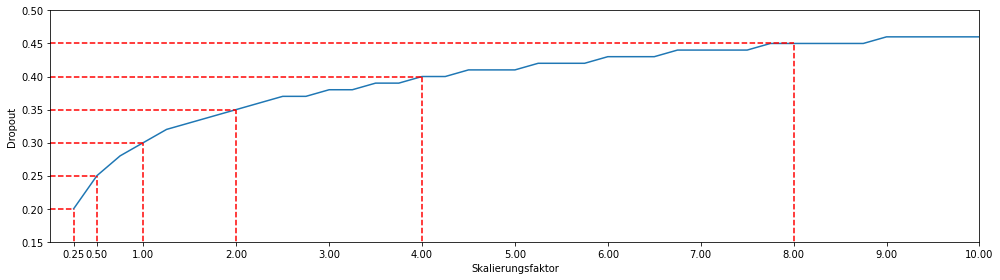

In [ ]:
import matplotlib.ticker as ticker
fig,ax = plt.subplots(figsize = (14,4), tight_layout = True)
sns.lineplot(x = x,y = y)

for i in [0.25,0.5,1,2,4,8]:
    plt.hlines(dropout(i), 0,i, edgecolor = "red", linestyle = "--")
    plt.vlines(i, 0,dropout(i), edgecolor = "red", linestyle = "--")
ax.set(xscale = "linear")
ax.set(xticks = [0.25,0.5, 1, 2, 3, 4,5,6,7,8,9,10]);
ax.set(xlim = [0,10])
ax.set(ylim=[0.15,0.5]);
ax.set(xlabel = "Skalierungsfaktor", ylabel = "Dropout")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

fig.savefig("Dropout_funktion.png")